<a href="https://colab.research.google.com/github/jpaguilarc99/Python-codes/blob/main/Remote_sensing_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
#Based on: CodeX For ML
#By: Juan Pablo Aguilar Calle

# **Clasificador de cobertura terrestre a través de imágenes satelitales EUROSAT**

In [ ]:
#Instalación de datasets de TensorFlow
!pip install tensorflow-datasets
#Search for datasets: https://www.tensorflow.org/datasets/catalog/overview

In [19]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input


**Se obtiene información del dataset de TensorFlow**

In [ ]:
dataset = tfds.builder('eurosat') #Trabajamos con el dataset de eurosat de 27.000 imagenes satelitales de cobertura terrestre (imagenes anotadas)
info = dataset.info #Obtenemos la info de eurosat
print(info)

**Trabajamos con el dataset RGB**

In [ ]:
info.features #Características de las imagenes para establecer los datos

In [ ]:
class_names = [] #Matriz de almacenamiento de labels de eurosat
for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names #Labels de eurosat

In [ ]:
list(info.splits.keys())

**El dataset contiene una división de entrenamiento de 27mil imagenes con 10 clases**

# **Importamos el dataset de TensorFlow**

In [ ]:
(train, val, test) = tfds.load("eurosat/rgb", split=["train[:80%]", "train[80%:90%]", "train[90%:]"]) #Definimos los conjuntos de train, validation y test de eurosat

In [9]:
type(train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
datapoint = next(iter(train))
datapoint

**Diccionario con 3 canales**

# **Visualizamos imagenes del Dataset**

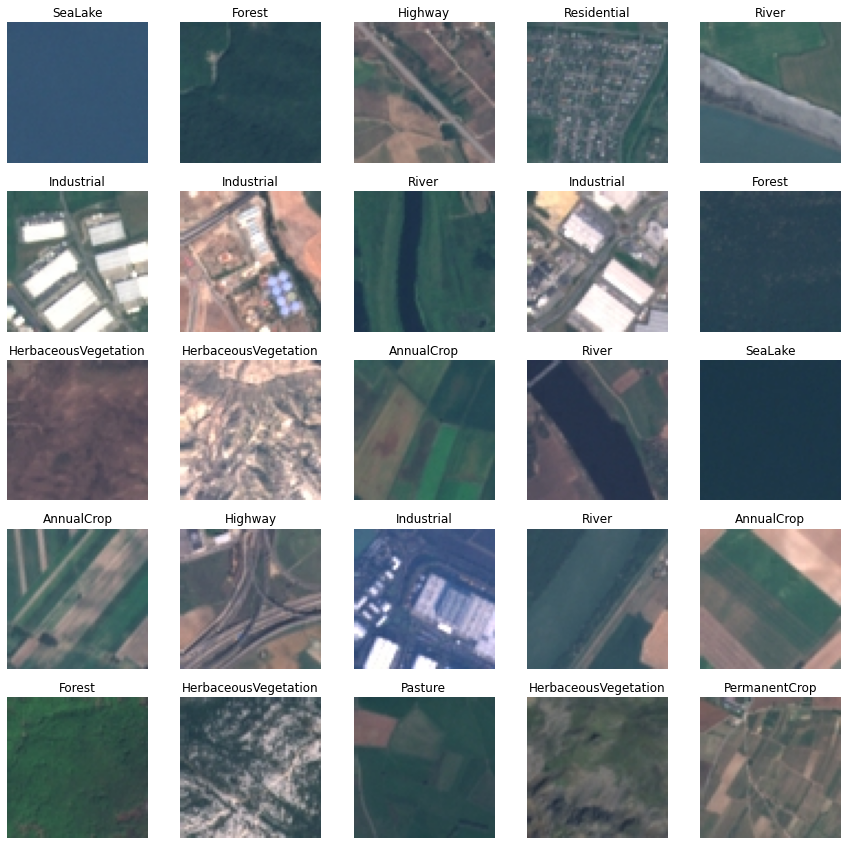

In [13]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(train.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()

**Definimos los parametros del modelo para el entrenamiento:**

In [29]:
NUM_EPOCHS = 10
BATCH_SIZE = 128
BUFFER_SIZE = 1000

IMAGE_SHAPE = [180, 180]
NUM_CLASSES = info.features["label"].num_classes

# **Data Augmentation**

In [17]:
tf.random.uniform(())  #Genera un número flotante aleatorio entre 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.7118151>

In [20]:
@tf.function #Generamos la función para tratar todo el dataset
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE) #Reescalamos el tamaño de las imagenes
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [21]:
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

# **Visualización de imágenes luego de su preprocesamiento**

**Se deben escalar las imágenes en [-1,1]**

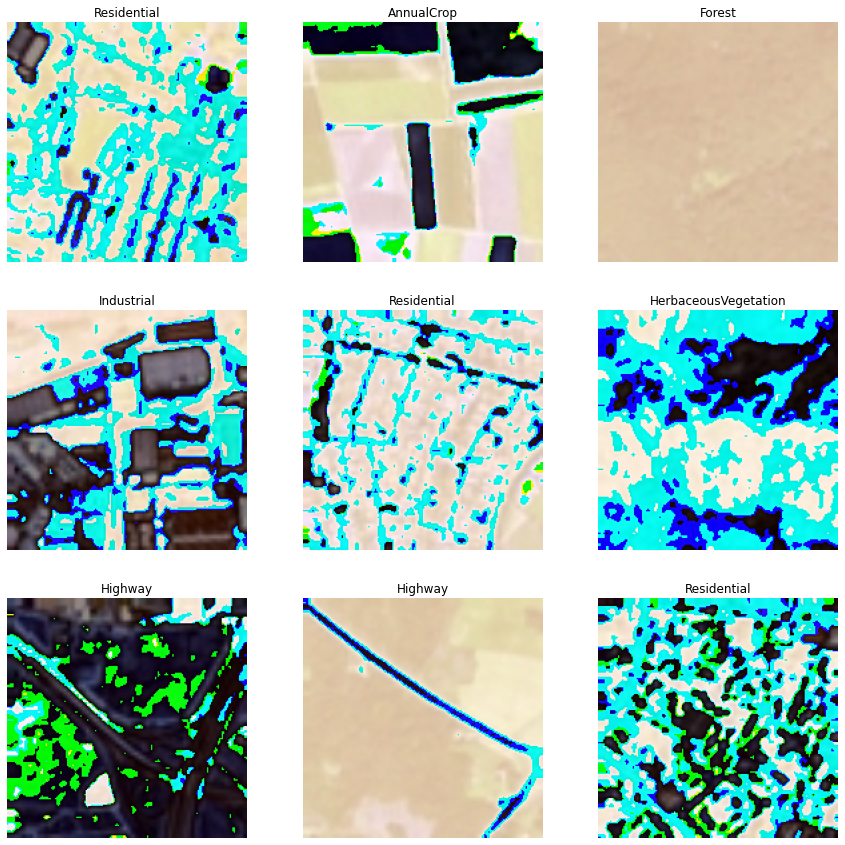

In [24]:
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  for datapoint in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(datapoint[0][0].astype('uint8'))
    plt.title(class_names[datapoint[1][0]])
    plt.axis("off")

plt.show()

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  for datapoint in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(datapoint[0][0])
    plt.title(class_names[datapoint[1][0]])
    plt.axis("off")

plt.show()

# **Construcción del modelo (ResNet50)**

In [ ]:
resnet = ResNet50(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False) #Cargamos ResNet50 haciendo Transfer Learning 

for layer in resnet.layers:
  layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x) 
predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=resnet.input, outputs=predicition)

**Compilación del modelo**

In [26]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
) #Se define la loss function y las metric a evaluar

In [27]:
STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.8)//BATCH_SIZE #Parametros de entrenamiento
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

**Entrenamiento del modelo:**

In [30]:
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/10
168/168 [==============================] - 110s 641ms/step - loss: 0.2581 - accuracy: 0.9135 - val_loss: 0.1437 - val_accuracy: 0.9528
Epoch 2/10
168/168 [==============================] - 106s 623ms/step - loss: 0.1192 - accuracy: 0.9590 - val_loss: 0.1122 - val_accuracy: 0.9617
Epoch 3/10
168/168 [==============================] - 105s 623ms/step - loss: 0.0810 - accuracy: 0.9722 - val_loss: 0.1489 - val_accuracy: 0.9542
Epoch 4/10
168/168 [==============================] - 105s 623ms/step - loss: 0.0587 - accuracy: 0.9804 - val_loss: 0.1374 - val_accuracy: 0.9602
Epoch 5/10
168/168 [==============================] - 105s 623ms/step - loss: 0.0407 - accuracy: 0.9870 - val_loss: 0.1387 - val_accuracy: 0.9572
Epoch 6/10
168/168 [==============================] - 105s 623ms/step - loss: 0.0300 - accuracy: 0.9906 - val_loss: 0.1495 - val_accuracy: 0.9609
Epoch 7/10
168/168 [==============================] - 105s 623ms/step - loss: 0.0223 - accuracy: 0.9938 - val_loss: 0.1455 -

**Visualizamos los resultados del entrenamiento:**

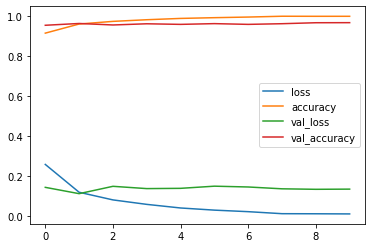

In [31]:
import pandas as pd #Visualización de resultados de entrnamiento

pd.DataFrame(
    history.history
).plot()

# **Evaluación de resultados**

In [32]:
test_dataset = test.map(prepare_validation_data) 
test_dataset = test_dataset.batch(BATCH_SIZE)

In [33]:
model.evaluate(test_dataset) #Estimación de precisión del modelo

22/22 [==============================] - 13s 554ms/step - loss: 0.1667 - accuracy: 0.9611


[0.16666944324970245, 0.9611111283302307]

**Precisión del 96.11%**

# **Predicción de coberturas terrestres**

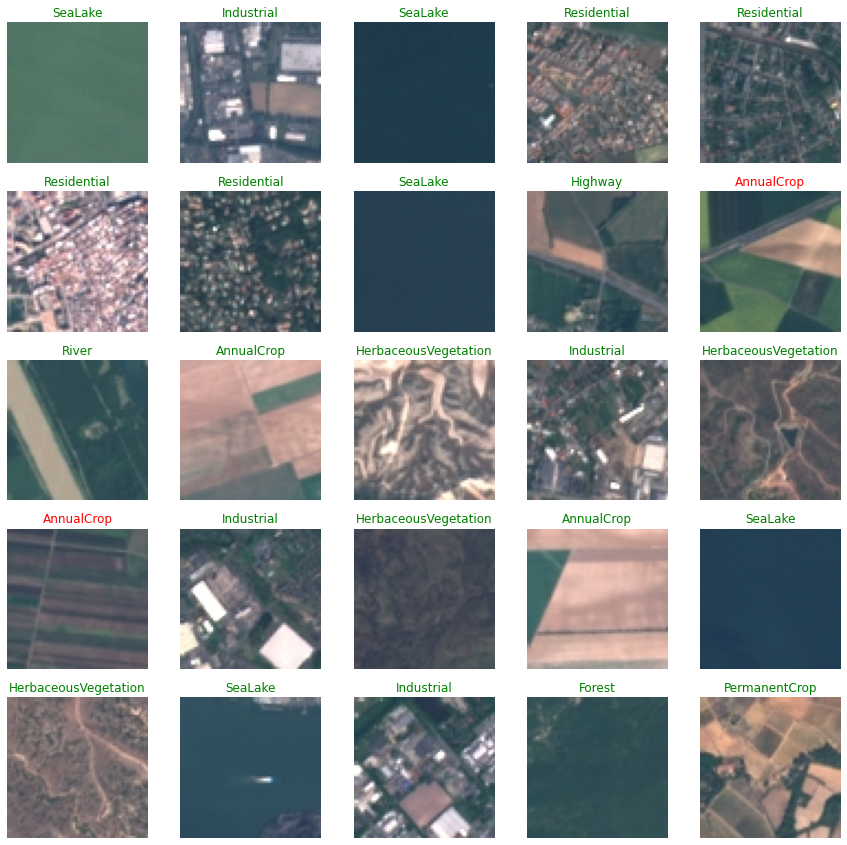

In [34]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()